# Table of Contents
## Version 1: Feedback dendrites have unlimited span+sparse connections
## Version 2: Feedback dendrites prefer nearest neighbor+sparse connections
## Version 3: Unlimited span+Fully connected

In [2]:
%reset
from bindsnet.network import Network
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.nodes import Input
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
import torch
import matplotlib.pyplot as plt
from torch import bernoulli, ones, randn
from time import time
from tqdm import tqdm

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from torchvision import transforms
import os

from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
#!echo "./data/MNIST" >> ./.gitignore ### run once only

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
total_timesteps = 500
dt = 1
num_epochs = 1
progress_interval = 10
update_interval = 250

intensity = 128

image_shape = (32, 32)
n_sensory_neurons = 100
n_output_neurons = n_sensory_neurons
dendrite_field_shape = (10, 10)
num_dendrite_layers = 1
input_neuron_weight = 5

seed = 8
batch_size = 1


torch.manual_seed(seed)
network = Network(dt=dt, learning=True, batch_size=1, reward_fn=None)

### In this setup, the physical weights between neurons don't change in the short term, only the dendritic feedback stimulation. Hence we first connect the network randomly.

# Version 1: Feedback dendrites have unlimited span but make relatively sparse connections

In [4]:
image_dim = image_shape[0]*image_shape[1]


input_layer = Input(n=image_dim, traces=True)
network.add_layer(input_layer, 'simulated input')

sensory_layer = LIFNodes(n=n_sensory_neurons, traces=True)
network.add_layer(sensory_layer, 'light-receptive neurons')

output_layer = LIFNodes(n=n_output_neurons, traces=True)
network.add_layer(output_layer, 'output neurons')

dendrite_layers_container = []
dendrite_dim = dendrite_field_shape[0]*dendrite_field_shape[1]

for iii in range(num_dendrite_layers):
    dendrite_layers_container.append(Input(n=dendrite_dim, traces=True))
    network.add_layer(dendrite_layers_container[iii], f"Dendrites {iii}")

In [5]:
(input_neuron_weight*torch.eye(input_layer.n, sensory_layer.n)).shape


torch.Size([1024, 100])

In [6]:
input_sensory_connection = Connection(
                source=input_layer,
                target=sensory_layer,
                w = input_neuron_weight*torch.rand(input_layer.n, sensory_layer.n))
network.add_connection(input_sensory_connection,
                       source='simulated input',
                       target='light-receptive neurons')

sensory_output_connection = Connection(
                source=sensory_layer,
                target=output_layer,
                w = 22.5*torch.diag(torch.ones(n_output_neurons))) #~10-1 connections to any given neuron
network.add_connection(sensory_output_connection,
                       source='light-receptive neurons',
                       target='output neurons')

dfs_dim = dendrite_field_shape[0]*dendrite_field_shape[1]
dendrite_sensory_connections_container = []

for iii in range(num_dendrite_layers):

    weights = torch.bernoulli(0.2*torch.ones(dendrite_layers_container[0].n, sensory_layer.n))
        #each feedback neuron connected to ~5 input neurons
    dendrite_sensory_connections_container.append(Connection(
                            source=dendrite_layers_container[iii],
                            target=sensory_layer,
                            w = weights*randn(weights.shape) ))
    
    network.add_connection(dendrite_sensory_connections_container[iii],
                           source=f"Dendrites {iii}",
                           target='light-receptive neurons')
[network.connections[iii].w.shape for iii in network.connections.keys()]

[torch.Size([1024, 100]), torch.Size([100, 100]), torch.Size([100, 100])]

In [7]:
 xxx = dendrite_sensory_connections_container[0].w
torch.count_nonzero(xxx)/dendrite_layers_container[0].n

tensor(20.8200)

In [8]:
xxxx = network.connections[('Dendrites 0','light-receptive neurons')].w
torch.count_nonzero(xxx)/dendrite_layers_container[0].n

tensor(20.8200)

### Visualizing data with no feedback convolution

In [9]:
train_dataset = MNIST(PoissonEncoder(time=total_timesteps, dt=dt),
                      None,
                      root = os.path.join(".", "data", "MNIST"),
                      download=True,
                      train=True,
                      transform = transforms.Compose(
                                  [transforms.Resize((32, 32)),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x*intensity)])
                     )

In [10]:
spikes = { }
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer],
                           state_vars = ["s"],
                           time = total_timesteps)
    network.add_monitor(spikes[layer], name = f"{layer} spikes")

voltages = { }
for layer in set(network.layers)-{"simulated input"}-set([f"Dendrites {iii}" for iii in range(num_dendrite_layers)]):
    voltages[layer] = Monitor(network.layers[layer],
                              state_vars = ["v"],
                              time=total_timesteps)
    network.add_monitor(voltages[layer], name = f"{layer} voltages")
network.monitors

{'Dendrites 0 spikes': <bindsnet.network.monitors.Monitor at 0x7fe3adc0fe80>,
 'simulated input spikes': <bindsnet.network.monitors.Monitor at 0x7fe3adc0fd30>,
 'output neurons spikes': <bindsnet.network.monitors.Monitor at 0x7fe474241ff0>,
 'light-receptive neurons spikes': <bindsnet.network.monitors.Monitor at 0x7fe474243cd0>,
 'output neurons voltages': <bindsnet.network.monitors.Monitor at 0x7fe3adc0fdf0>,
 'light-receptive neurons voltages': <bindsnet.network.monitors.Monitor at 0x7fe3adc43430>}

In [14]:
network.monitors['output neurons spikes'].get('s')

tensor([])

In [610]:
start = time()
training_pairs=[]

train_dataloader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True,)

def forward(datum, stim):
    
    datum = next(iter(train_dataloader))

    image = datum["encoded_image"]
    label = datum["label"]
    
    inputs = {"simulated input": image.view(total_timesteps, 1, image_dim),
             "Dendrites 0": stim}

    network.run(inputs, time=total_timesteps)

    spikes_ = {layer: spikes[layer].get("s") for layer in spikes}
    voltages_ = {layer: voltages[layer].get("v") for layer in voltages}


    plt.ioff()
    plot_voltages(voltages_, plot_type="line")
    plot_spikes(spikes_)
    raw_im = datum["image"].view(32, 32)
    inpt = spikes_["output neurons"].view(total_timesteps, n_output_neurons).sum(0).view(10, 10)
    plot_input(raw_im, inpt, label=label)


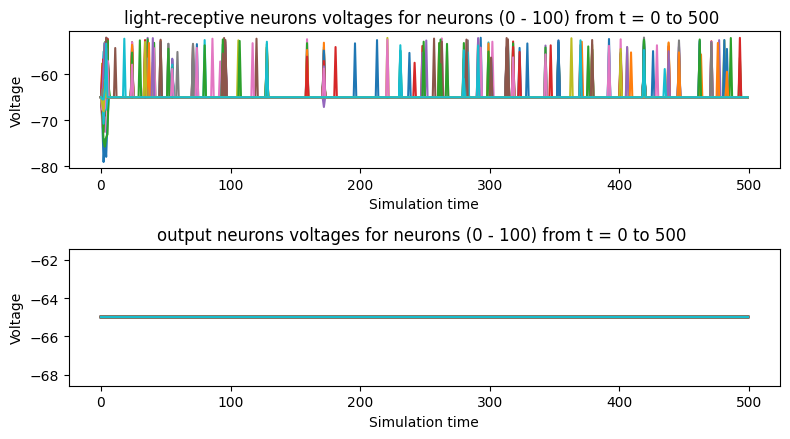

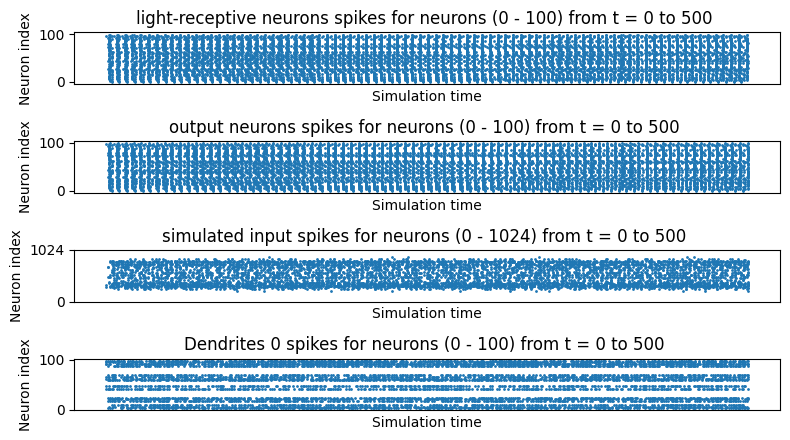

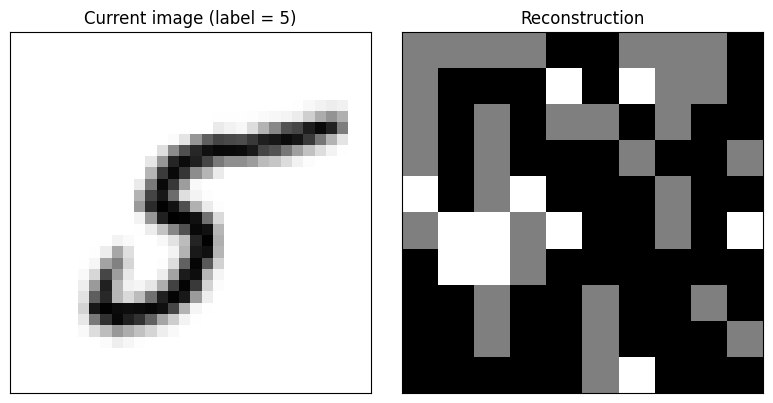

In [611]:
#making sparse spiking for dendrite layer
xxx = 0.9*bernoulli((40/256)*torch.ones((1, 10*10)))
xxx = xxx.expand(500, 1, 10*10)
xxx = torch.poisson(xxx)
    
forward(next(iter(train_dataloader)), xxx)
plt.show()

In [617]:
spikes['light-receptive neurons'].get('s').squeeze()
label = torch.tensor([5])

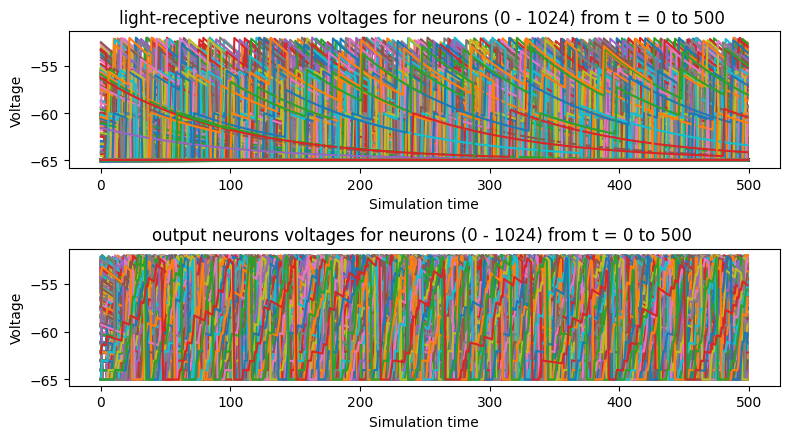

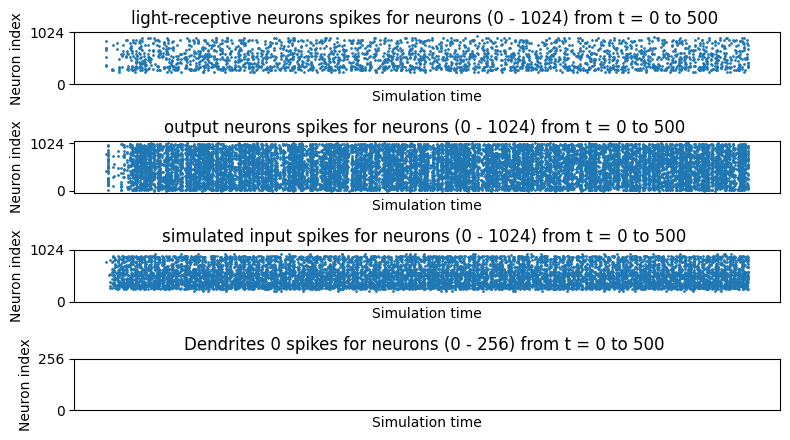

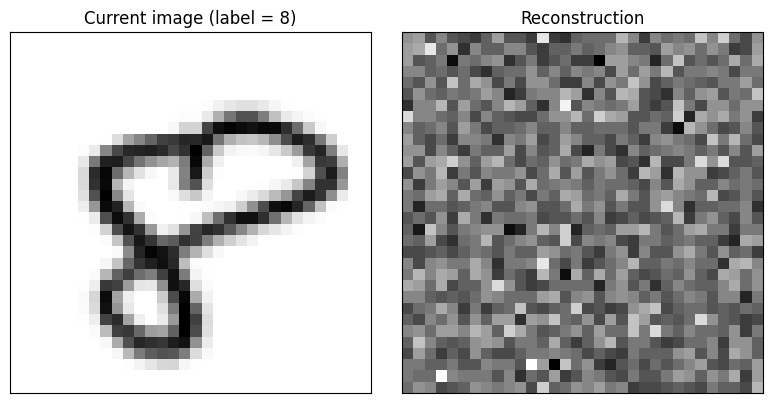

In [387]:
test2 = torch.zeros((total_timesteps, 1, 256)).byte()

forward(next(iter(train_dataloader)), test2)
plt.show()

In [595]:
from time import time as t
n_neurons = 100
n_classes = 10
n_epochs=2
n_train = 600
assigments = -torch.ones(n_neurons)
proportions = torch.zeros(n_neurons, n_classes)
rates = torch.zeros((n_neurons, n_classes))
spike_record = torch.zeros((update_interval, int(total_timesteps / dt), n_neurons))

accuracy = {'all': [], "proportion": []}
start = t()
for epoch in range(n_epochs):
    labels = []
    for step, batch in enumerate(train_dataloader):
        if step > n_train:
            break
        # Get next input sample.
        inputs = {"simulated input": batch["encoded_image"].view(int(total_timesteps / dt), 1, 1, 32, 32)}

        if step % update_interval == 0 and step > 0:
            # Convert the array of labels into a tensor
            label_tensor = torch.tensor(labels)

            # Get network predictions.
            all_activity_pred = all_activity(
                spikes=spike_record, assignments=assignments, n_labels=n_classes
                )
            proportion_pred = proportion_weighting(
                spikes=spike_record,
                assignments=assignments,
                proportions=proportions,
                n_labels=n_classes,
                )

            # Compute network accuracy according to available classification strategies.
            accuracy["all"].append(
                100
                * torch.sum(label_tensor.long() == all_activity_pred).item()
                / len(label_tensor)
                )
            accuracy["proportion"].append(
                100
                * torch.sum(label_tensor.long() == proportion_pred).item()
                / len(label_tensor)
                )

            print(
                "\nAll activity accuracy: %.2f (last), %.2f (average), %.2f (best)"
                % (
                    accuracy["all"][-1],
                    np.mean(accuracy["all"]),
                    np.max(accuracy["all"]),
                )
                )
            print(
                "Proportion weighting accuracy: %.2f (last), %.2f (average), %.2f"
                " (best)\n"
                % (
                    accuracy["proportion"][-1],
                    np.mean(accuracy["proportion"]),
                    np.max(accuracy["proportion"]),
                )
                )

            # Assign labels to excitatory layer neurons.
            assignments, proportions, rates = assign_labels(
                spikes=spike_record,
                labels=label_tensor,
                n_labels=n_classes,
                rates=rates,
                )

            labels = []

        labels.append(batch["label"])

        # Run the network on the input.
        network.run(inputs=inputs, time=total_timesteps)

        # Get voltage recording.
        output_voltages = voltages['light-receptive neurons'].get("v")
        inh_voltages = voltages['output neurons'].get("v")

        # Add to spikes recording.
        spike_record[step % update_interval] = spikes["output neurons"].get("s").squeeze()

KeyboardInterrupt: 

# Version 2: Feedback dendrites prefer nearest neighbor, relatively sparse connections

# Version 3: Feedback dendrites have unlimited span and connect to all